In [1]:
import numpy as np
import pandas as pd

from train import *
from data import load_data, load_config, z_score_normalize, split_train_val
from matplotlib import pyplot as plt

np.random.seed(seed = 100) # fix the random seed to make things reproducible

## (a) Loading Data

In [2]:
train_val = load_data()
train_val[0].shape, train_val[1].shape

((60000, 784), (60000,))

In [3]:
test_set = load_data(train=False)
test_set[0].shape, test_set[1].shape

((10000, 784), (10000,))

In [4]:
# load config as well
config = load_config(("./config.yaml"))

### Pre-process
#### Normalization

In [5]:
train_x, train_y = train_val
train_x, _ = z_score_normalize(train_x)
train_val = train_x, train_y

test_x, test_y = test_set
test_x, _ = z_score_normalize(test_x)
test_set = test_x, test_y

#### Split Data

In [6]:
x_train, y_train, x_val, y_val = split_train_val(train_val, 0.8)
x_test, y_test = test_set

## (b) Check gradient implementation

We only use an example of data to do this part. Thus, we use 1000 random data from the train/validation set.

In [7]:
pd.DataFrame(check_gradients(train_val, config), columns=["name of weight", "difference", "actual gradient", "estimated gradient"])

,name of weight,difference,actual gradient,estimated gradient
0,output bias,2.0322590583467248e-07,0.012671104872593866,0.0126713080984997
1,hidden bias,2.8679598496478276e-06,-0.1182257632568207,-0.11822289529697105
2,hidden-output weight_1,7.966632269151841e-08,0.009273564165974427,0.009273643832297118
3,hidden-output weight_2,8.285477127133178e-08,0.009660359079762365,0.009660441934533637
4,input-hidden weight_1,3.513123377277272e-10,0.005871529380401278,0.00587152902908894
5,input-hidden weight_2,2.677261424707811e-10,-0.005488742979949136,-0.005488742712222994


## (c) Train Multiple-Layers Perceptron

### With default configrations
#### NOTE: early_stopping=False

In [8]:
print(config)

{'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': False, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8413


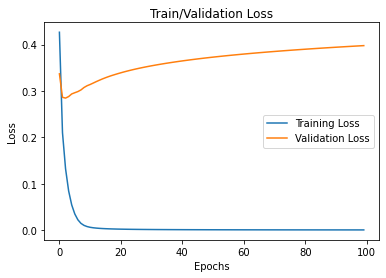

In [9]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

test_loss, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

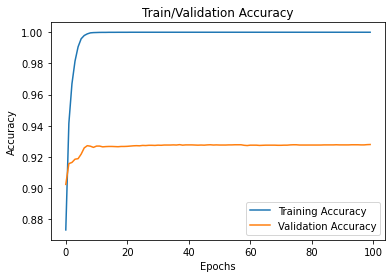

In [10]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### Change some hyper-parameters to avoid overfitting

Since the early-stopping is disabled, we enable the early-stopping.

In [11]:
config["early_stop"] = True
print(config)

{'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8397


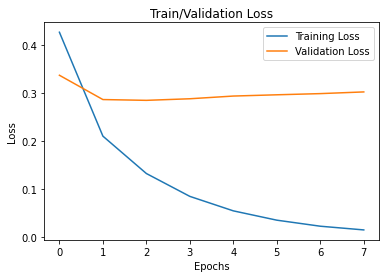

In [12]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

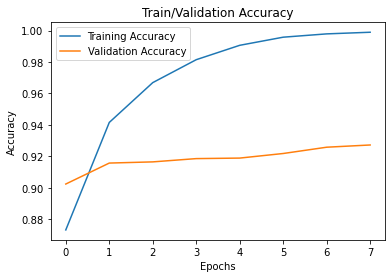

In [13]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

## (d) Experiment with Regularization

#### enable early stopping, and 10% more max epoch number, and experiment with L2 regularization of 1e-3

In [14]:
config["early_stop"] = True
config["epochs"] = 110
config["L2_penalty"] = 1e-3
print(config)

{'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 110, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8364


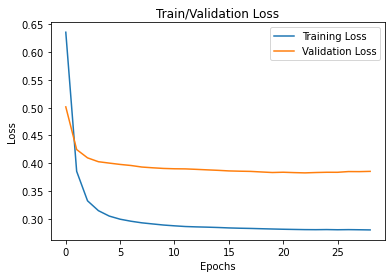

In [15]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config, experiment="L2")

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

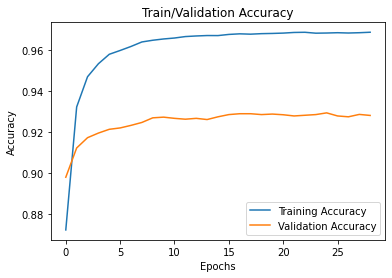

In [16]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### enable early stopping, and 10% more max epoch number, and experiment with L2 regularization of 1e-6

In [17]:
config["L2_penalty"] = 1e-6
print(config)

{'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 110, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 1e-06, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8412


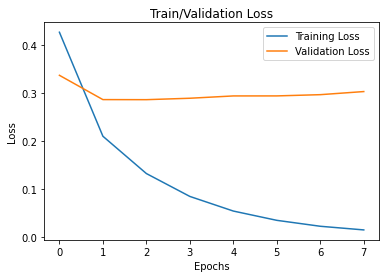

In [18]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config, experiment="L2")

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

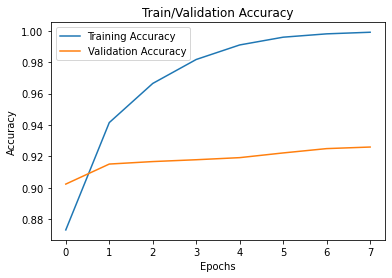

In [19]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### enable early stopping, and 10% more max epoch number, and experiment with L1 regularization of 1e-6

In [20]:
print(config)

{'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 110, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 1e-06, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8433


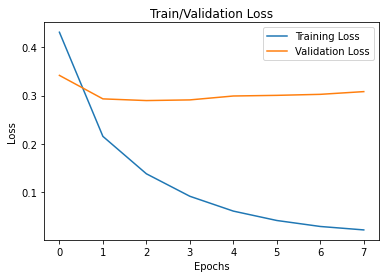

In [21]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config, experiment="L1")

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

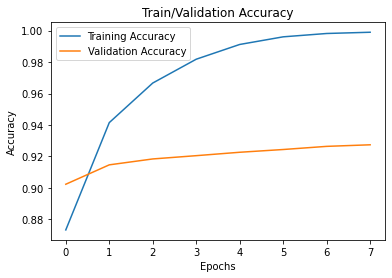

In [22]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

## (e) Experiment with Activation

#### Experiment with Sigmoid

In [23]:
# reset the config to part(c) config
config = load_config("./config.yaml")
config["early_stop"] = True

# change the activation function to sigmoid
config["activation"] = "sigmoid"

print(config)

{'layer_specs': [784, 128, 10], 'activation': 'sigmoid', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8489


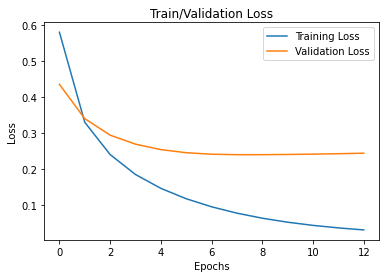

In [24]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

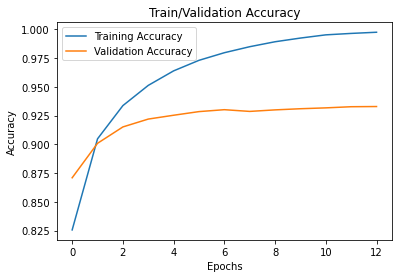

In [25]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### Experiment with ReLU

In [26]:
# change the activation function to ReLU
config["activation"] = "ReLU"

print(config)

{'layer_specs': [784, 128, 10], 'activation': 'ReLU', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.7969


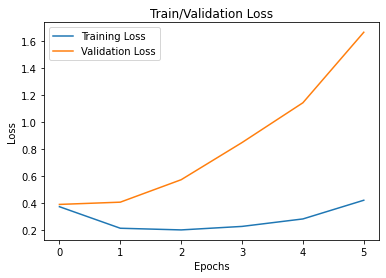

In [27]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

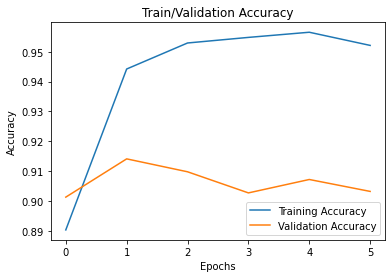

In [28]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

## (f) Experiment with Network Topology

#### Halving the number of hidden units

In [29]:
# reset the config to part(c) config
config = load_config(("./config.yaml"))
config["early_stop"] = True

# change the topology
config["layer_specs"] = [784, 64, 10]

print(config)

{'layer_specs': [784, 64, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.7972


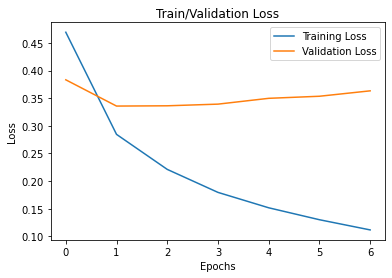

In [30]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

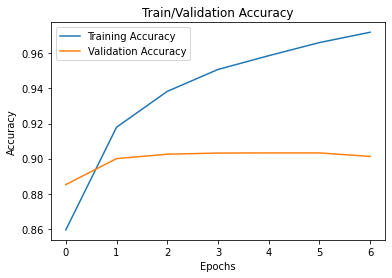

In [31]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### Doubling the number of hidden units

In [32]:
# change the topology
config["layer_specs"] = [784, 256, 10]

print(config)

{'layer_specs': [784, 256, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8596


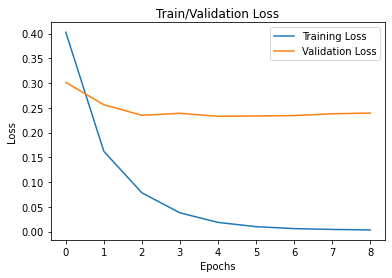

In [33]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

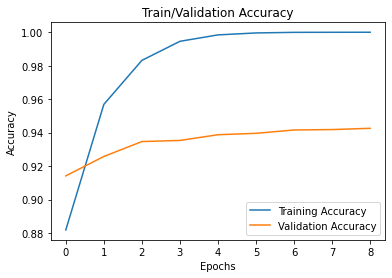

In [34]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#### Use two hidden layers but keep similar amount of weights

The part(c) model has 101770 number of weights: $$784 * 128 + 128 + 128 * 10 + 10 = 101770$$

Thus, we need two same size hidden layers to get roughly same number of weight. We decided to use two hidden layers with 112 hidden units. Therefore, the number of weight is: $$784 * 112 + 112 + 112 * 112 + 112 + 112 * 10 + 10 = 101706$$

In [35]:
# change the activation function to sigmoid
config["layer_specs"] = [784, 112, 112, 10]

print(config)

{'layer_specs': [784, 112, 112, 10], 'activation': 'tanh', 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 5, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}


test accuracy: 0.8419


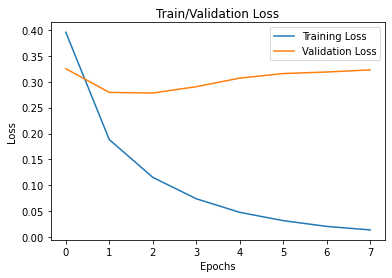

In [36]:
train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train, y_train, x_val, y_val, config)

_, test_acc = test(best_model, x_test, y_test)

print("test accuracy:", test_acc)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

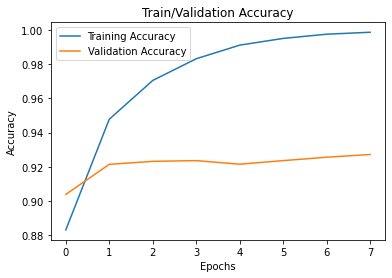

In [37]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])